In [1]:
from __future__ import print_function, division

import torch
import torch.optim as optim

from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import time
import os

import torch.nn as nn

# TODO: You can modify the network architecture
class Net(nn.Module):
    """
    Input - 1x32x32
    Output - 10
    """
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, padding=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(p=0.3),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(p=0.3),

            nn.Flatten(), 
            nn.Linear(256*4*4, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
            )
        
    def forward(self, xb):
        return self.network(xb)

In [2]:
from random import randrange
# TODO: You can try different augmentation strategies
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomChoice([transforms.Pad(padding=4, fill=(randrange(256),randrange(256),randrange(256))), transforms.ElasticTransform(),transforms.GaussianBlur((3,3))]),
        transforms.RandomGrayscale(0.15),
        transforms.RandomAffine(degrees=10, translate=(0,0.1)),
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),

    ]),
    'test': transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

In [3]:
data_dir = '/kaggle/input/dtc314/data' # Suppose the dataset is stored under this folder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']} # Read train and test sets, respectively.

train_dataloader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=128,
                                             shuffle=True, num_workers=4)

test_dataloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=128,
                                             shuffle=False, num_workers=4)

train_size =len(image_datasets['train'])


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Set device to "cpu" if you have no gpu

In [4]:
history = dict()

def train_test(model, criterion, optimizer, scheduler, num_epochs=25):
    train_loss = []
    train_accuracy = []
    val_loss = [] 
    val_accuracy = []
    model.train()
    for epoch in range(num_epochs):
        running_training_loss = 0.0
        running_training_accuracy = 0.0
        iteration_training_loss = 0.0
        total_training_predictions = 0
       
        start_time = time.time()
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_training_loss += loss.item()*inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total_training_predictions += labels.size(0)
            running_training_accuracy += (predicted == labels).sum().item()
            iteration_training_loss += loss.item() 
            if (i+1) % 100 == 0:
                print('Epoch:[%d]-Iteration:[%d], training loss: %.3f' %
                      (epoch + 1,i+1,iteration_training_loss/(i+1)))
        end_time = time.time()
        print('Time cost of one epoch: [%d]s' % (end_time-start_time))
        
        epoch_training_accuracy = running_training_accuracy / train_size*100
        epoch_training_loss = running_training_loss / train_size
        
        print('Epoch:[%d], training accuracy: %.1f, training loss: %.3f' %
              (epoch + 1,epoch_training_accuracy, epoch_training_loss))
        
        train_loss.append(epoch_training_loss)
        train_accuracy.append(epoch_training_accuracy)
        
        correct = 0
        total = 0
        labelsCorrect = [0 for i in range(10)]
        labelsTotal = [0 for i in range(10)]
        model.eval()
        # Since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in test_dataloader:
                images, labels = data[0].to(device), data[1].to(device)
                # calculate outputs by running images through the network
                outputs = model(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                tmp = (predicted == labels)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                for i in range(labels.size(0)): 
                    label = labels.data[i]
                    labelsCorrect[label] += tmp[i]
                    labelsTotal[label] += 1
        accuracy = float(100) * correct / total
        print(f'Accuracy of the network on test images: {accuracy}')
        for i in range(10): 
            acc = (labelsCorrect[i]/labelsTotal[i]).item
            print(f"Test Accuracy of {i}: {round((labelsCorrect[i]/labelsTotal[i]).item()*100,2)}")        
        val_accuracy.append(accuracy)
        scheduler.step()
        
    print('Finished Training')

    history['train_loss'] = train_loss
    history['train_accuracy'] = train_accuracy
    history['val_accuracy'] = val_accuracy

    return history, accuracy


In [5]:
epoch = 50

if __name__ == '__main__':
    end = time.time()
    model_ft = Net().to(device) # Model initialization
    print(model_ft.network)
    criterion = nn.CrossEntropyLoss() # Loss function initialization

    # TODO: Adjust the following hyper-parameters: initial learning rate, decay strategy of the learning rate, 
    #       number of training epochs
    optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001) # The initial learning rate is 1e-3

    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1) 
    
    history, accuracy = train_test(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
               num_epochs=epoch)
    
    print("time required %.2fs" %(time.time() - end))

Sequential(
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.3, inplace=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.3, inplace=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=4096, out_features=128, bias=True)
  (14): ReLU()
  (15): Linear(in_features=128, out_features=10, bias=True)
)
Epoch:[1]-Iteration:[100], training loss: 2.304
Epoch:[1]-Iteration:[200], training loss: 2.154
Time cost of one epoch: [88]s
Epoch:[1], training accuracy: 22.7, training loss: 2.054
Accuracy of the network on test ima

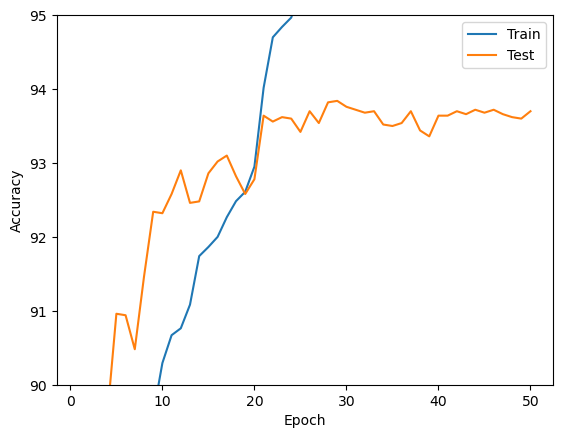

Epoch with max test accuracy: 1


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(range(1,epoch+1)), history["train_accuracy"], label="Train")
plt.plot(list(range(1,epoch+1)), history["val_accuracy"], label="Test")
plt.xlabel("Epoch")
ax = plt.gca()
ax.set_ylim([90, 95])
plt.ylabel("Accuracy")
plt.legend()
plt.show()
print("Epoch with max test accuracy:", history["val_accuracy"].index(min(history["val_accuracy"]))+1)
